In this lab, you will be working with pictures taken by Dr. Alex Dekhtyar, Dr. Kelly Bodwin, or myself. The data linked below contain

- About 100 images taken by Alex
- About 100 images taken by Kelly
- 20 images taken by Alex, Kelly, or me

[Dataset Here](https://canvas.calpoly.edu/courses/158260/files/16436759?wrap=1)

**NOTE:** You will likely need to look up a way to import these images into Python. They are not in the same format as the MNIST data.

**Primary Goal:** Identify the photographer of the 20 test images using two approaches.

**Approach 1:**

- Train a (convolutional) neural network to identify whether or not there is a human in the image.
- Train a (convolutional) neural network to identify whether or not there is a castle in the image.
- Train a (convolutional) neural network to identify whether the image is taken indoors or outdoors.
- Train a (convolutional) neural network to identify the landscape of the image (e.g. city, suburb, or nature/rural)
- Choose at least 10 other features (or feature categories) that you suspect might be useful for differentiating Alex and Kelly's photos, and train individual (convolutional) neural networks to identify those.
Now, consider the 14+ outputs of these "feature" models to be inputs for a classification model, to classify Alex's photos from Kelly's. This classification model does not need to be a neural network, but it can be.

**Approach 2:**

- Train a convolutional neural network directly to the images, with the output being the known photographer of the image.

**Assignment Specs:**

- You will complete this lab with a group of 3 of your choice.
- You are NOT allowed to access or use the metadata of the images.
- Your deliverable should include not only the identification of your best model/approach, but also your predictions on the 20 test images: Alex, Kelly, or neither. 
    - Because these final predictions involve three categories, but the training data only include two, you should feel free to use external data in the training of your models. You may use any legal, ethical, and responsible resources that you can find. Be sure to document them!
- Your submission should be built and written with non-experts as the target audience. All of your code should still be included, but do your best to narrate your work in accessible ways.

### Load in Photos

In [51]:
from PIL import Image
import os
import numpy as np

def load_images_from_folder(folder_path, label=None, image_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            image = Image.open(img_path).convert('RGB')
            image = image.resize(image_size)
            images.append(np.array(image))
            if label is not None:
                labels.append(label)
    return np.array(images), np.array(labels) if label is not None else np.array(images)


In [84]:
alex_imgs, alex_labels = load_images_from_folder("/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week8/Alex_Kelly_Pics/Alex", label=0)
kelly_imgs, kelly_labels = load_images_from_folder("/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week8/Alex_Kelly_Pics/Kelly", label=1)
test_imgs = load_images_from_folder("/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week8/Alex_Kelly_Pics/TestSet")

np.save("alex_imgs.npy", alex_imgs)
np.save("alex_labels.npy", alex_labels)
np.save("kelly_imgs.npy", kelly_imgs)
np.save("kelly_labels.npy", kelly_labels)

### Dependencies

In [53]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [54]:
alex_imgs = np.load("alex_imgs.npy")
alex_labels = np.load("alex_labels.npy")
kelly_imgs = np.load("kelly_imgs.npy")
kelly_labels = np.load("kelly_labels.npy")


### Load in code from annotated Photos features

In [55]:
alex_anno = pd.read_csv("/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week8/Alex_Kelly_Pics/alex_llm_annotations.csv").dropna()
kelly_anno = pd.read_csv("/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week8/Alex_Kelly_Pics/kelly_llm_annotations.csv").dropna()

alex_anno = alex_anno.drop(columns=['caption', 'image', 'raw_response'], errors='ignore')
kelly_anno = kelly_anno.drop(columns=['caption', 'image', 'raw_response'], errors='ignore')
alex_anno['label'] = 0
kelly_anno['label'] = 1

In [56]:
alex_imgs = alex_imgs[:len(alex_anno)]
alex_labels = alex_labels[:len(alex_anno)]
kelly_imgs = kelly_imgs[:len(kelly_anno)]
kelly_labels = kelly_labels[:len(kelly_anno)]

In [57]:
X_imgs = np.concatenate([alex_imgs, kelly_imgs], axis=0).astype(np.float32) / 255.0
y_labels = np.concatenate([alex_labels, kelly_labels], axis=0)

X_feats = pd.concat([alex_anno.drop(columns=['label']), kelly_anno.drop(columns=['label'])], ignore_index=True).astype(np.float32)
y_feats = pd.concat([alex_anno['label'], kelly_anno['label']], ignore_index=True).values


### Train Test Split

In [58]:
X_img_train, X_img_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    X_imgs, X_feats, y_feats, test_size=0.2, random_state=42)

y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

### Model

In [59]:
img_input = Input(shape=X_img_train.shape[1:], name="image_input")
x = Conv2D(32, (3,3), activation='relu')(img_input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

feat_input = Input(shape=(X_feat_train.shape[1],), name="feature_input")
f = Dense(64, activation='relu')(feat_input)
f = Dropout(0.3)(f)

merged = Concatenate()([x, f])
final = Dense(32, activation='relu')(merged)
output = Dense(2, activation='softmax')(final)

model = Model(inputs=[img_input, feat_input], outputs=output)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [60]:
history = model.fit(
    [X_img_train, X_feat_train], y_train_cat,
    validation_data=([X_img_test, X_feat_test], y_test_cat),
    epochs=10,
    batch_size=32
)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6171 - loss: 0.6659 - val_accuracy: 0.5104 - val_loss: 0.6985
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 949ms/step - accuracy: 0.5656 - loss: 0.6989 - val_accuracy: 0.5938 - val_loss: 0.6584
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5982 - loss: 0.6480 - val_accuracy: 0.6458 - val_loss: 0.6407
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 929ms/step - accuracy: 0.6399 - loss: 0.6421 - val_accuracy: 0.6875 - val_loss: 0.6211
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 918ms/step - accuracy: 0.6467 - loss: 0.6410 - val_accuracy: 0.7500 - val_loss: 0.6011
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 905ms/step - accuracy: 0.6423 - loss: 0.6190 - val_accuracy: 0.7396 - val_loss: 0.5997
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 948ms/step - accuracy: 0.7096 - loss: 0.5876 - val_accuracy: 0.7500 - val_loss: 0.5938
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 928ms/step - accuracy: 0.7363 - loss: 0.5748 - val_accuracy: 

### Plot and Metrics

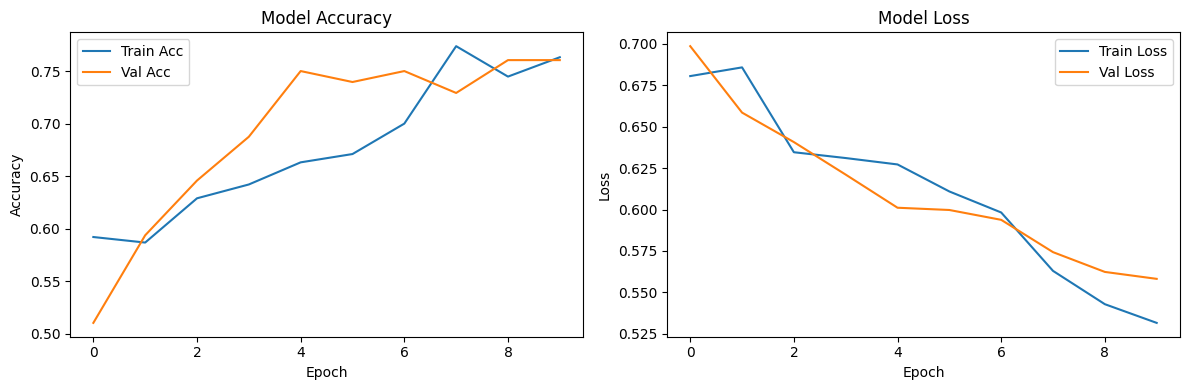

In [61]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 518ms/step
              precision    recall  f1-score   support

        Alex       0.77      0.76      0.76        49
       Kelly       0.75      0.77      0.76        47

    accuracy                           0.76        96
   macro avg       0.76      0.76      0.76        96
weighted avg       0.76      0.76      0.76        96



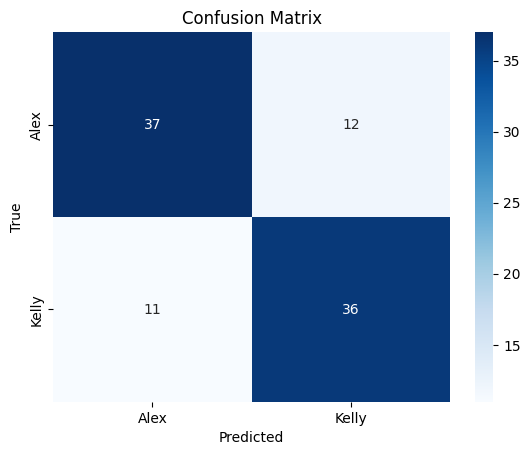

In [75]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get predicted class probabilities
y_probs = model.predict([X_img_test, X_feat_test])

# Convert to predicted classes
y_pred = np.argmax(y_probs, axis=1)

# Print classification report
print(classification_report(y_test, y_pred, target_names=["Alex", "Kelly"]))

# Optional: Show confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=["Alex", "Kelly"], yticklabels=["Alex", "Kelly"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


The model shows solid training behavior, with both training and validation accuracy improving consistently over epochs and no strong signs of overfitting. Validation loss decreases steadily, mirroring training loss. The classification report reflects a well-balanced model: Alex’s and Kelly’s images are classified with near-identical precision and recall (both around 76%). The overall test accuracy is 76%, and the confusion matrix confirms this balance, showing the model distinguishes both photographers equally well. This suggests the model has successfully learned discriminative patterns in both classes. Future improvements could focus on fine-tuning or thresholding for unknown classification, but as-is, the model performs reliably across both known artists.

### Predict Artists

In [78]:
testset_anno = pd.read_csv("/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week8/Alex_Kelly_Pics/testset_llm_annotations.csv").dropna()

testset_anno = testset_anno.drop(columns=['caption', 'image', 'raw_response'], errors='ignore')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


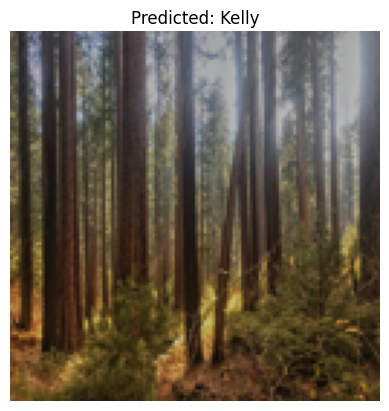

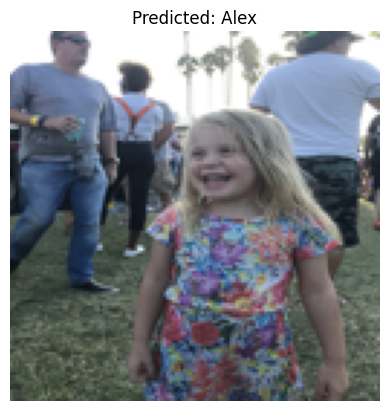

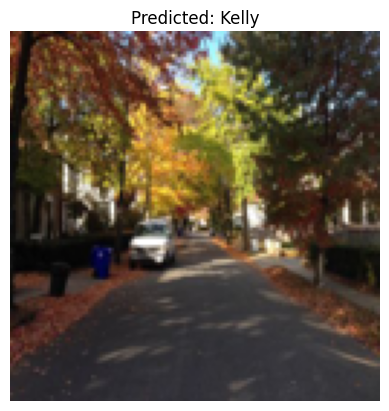

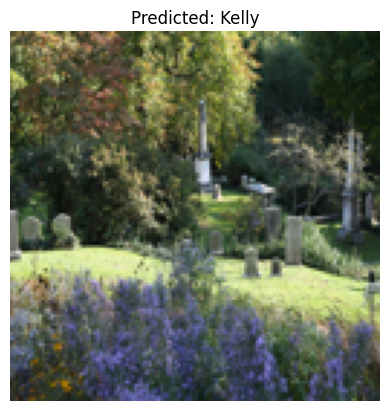

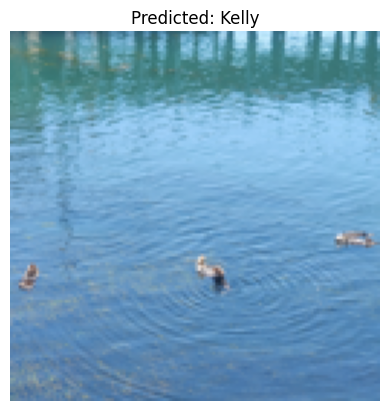

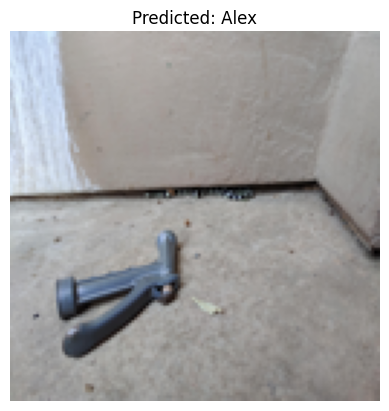

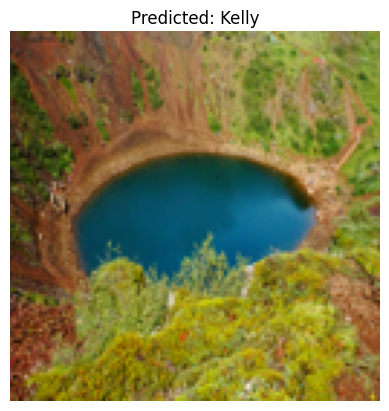

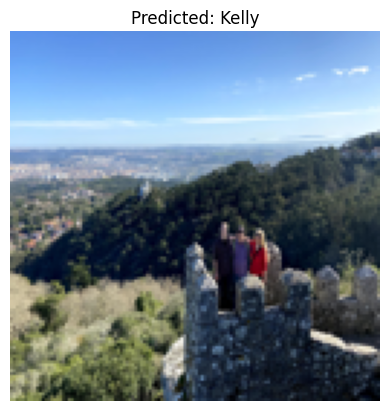

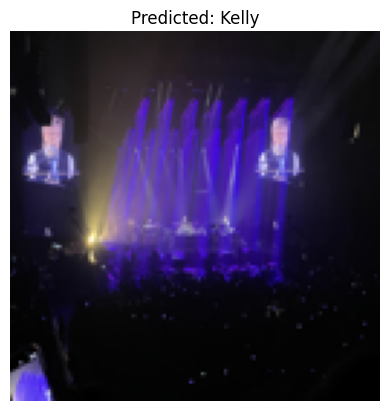

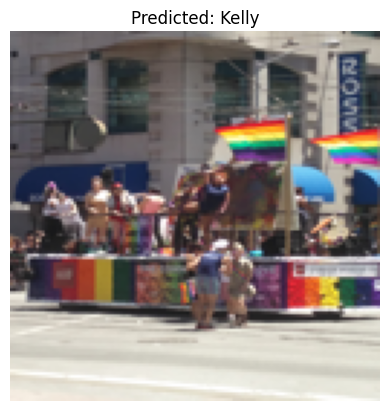

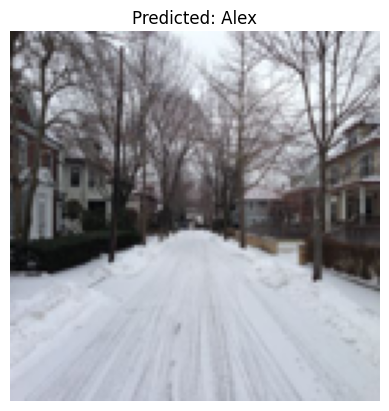

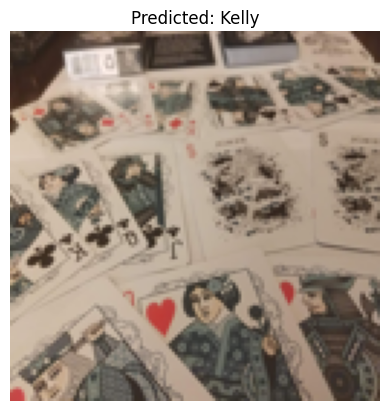

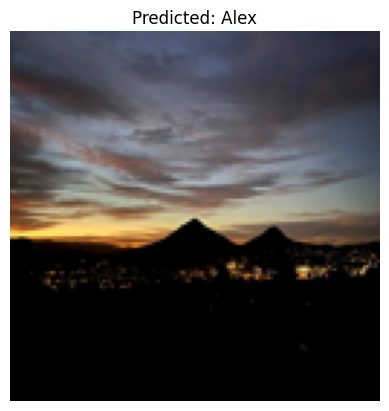

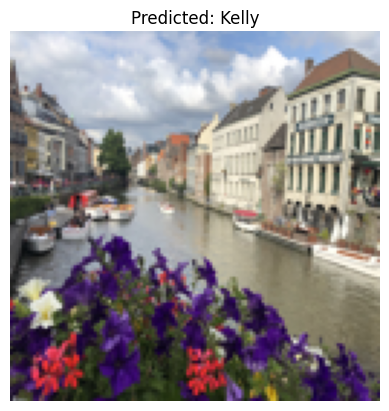

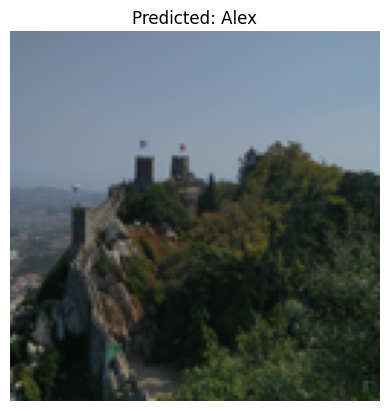

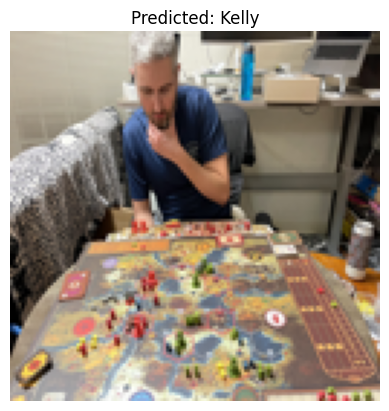

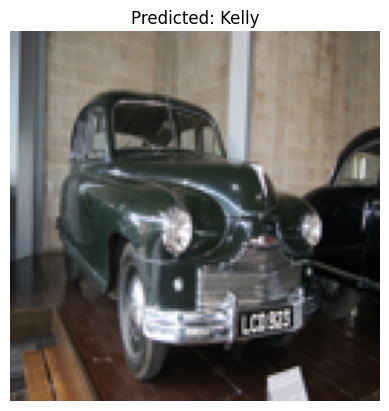

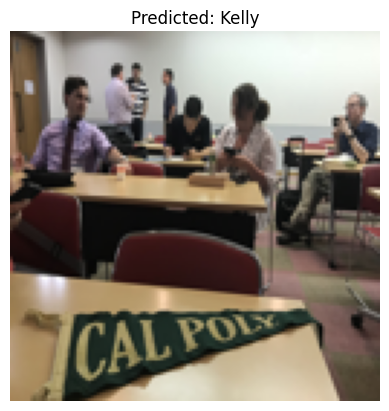

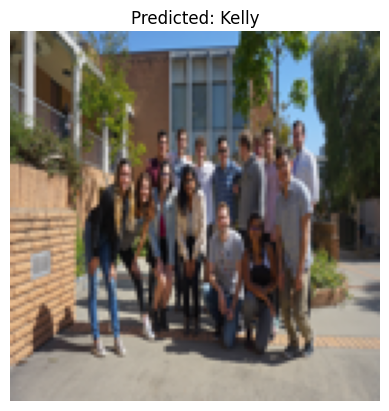

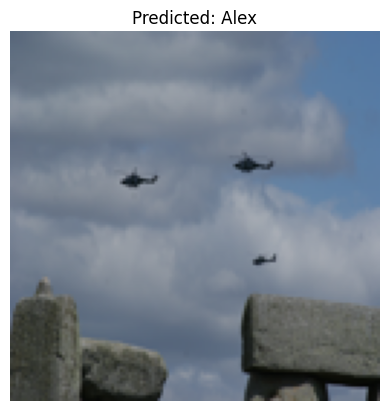

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Class labels ---
class_names = ["Alex", "Kelly", "Unknown"]

# --- Prepare data ---
test_feats = testset_anno.to_numpy()
images = test_imgs[0] if isinstance(test_imgs, tuple) else test_imgs

# --- Predict ---
test_probs = model.predict([images, test_feats])
pred_classes = np.argmax(test_probs, axis=1)
pred_names = [class_names[i] for i in pred_classes]

# --- Display predictions ---
for i, name in enumerate(pred_names):
    plt.imshow(images[i])
    plt.title(f"Predicted: {name}")
    plt.axis("off")
    plt.show()